# Data preparation

This notebook presents the code used to create a dataset of roof images.

In [ ]:
%matplotlib inline
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import sys
from owslib.wms import WebMapService
import shapefile
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import os
import ogr
import shapely
from shapely.geometry import *
import geopandas as gpd
from six.moves import cPickle as pickle
import math

In [ ]:
np.random.seed(seed=125)

## Footprints selection

In [11]:
# The buildings foortprints are loaded from a Shapefile
all_buildings = gpd.read_file('data/geo/buildings.shp')
all_buildings = all_buildings.to_crs({'init': 'epsg:2154'})

In [12]:
city_center = gpd.read_file('data/geo/city_center.shp')
city_center = city_center.to_crs({'init': 'epsg:2154'})

In [61]:
len(all_buildings)

331334

In [14]:
in_city_center = []
for i,building in all_buildings.iterrows():
    in_city_center.append(building.geometry.within(city_center.geometry[0]))

In [74]:
# The buildings that are in the city center are removed
buildings = all_buildings[[not bg for bg in in_city_center]]

In [75]:
len(buildings)

300291

In [76]:
no_light_bg = buildings['type']=='Bâti dur'

In [77]:
# The buildings that are light constructions are removed
buildings = buildings[no_light_bg]

In [78]:
len(buildings)

200930

[<matplotlib.text.Text at 0x12ee695f8>, <matplotlib.text.Text at 0x11d858e80>]

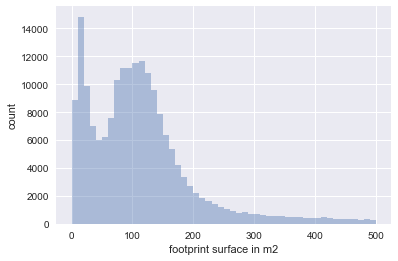

In [79]:
ax = sns.distplot(buildings[buildings.area<500].area,kde=False)
ax.set(xlabel='footprint surface in m2', ylabel='count')

In [80]:
# The buildings that have a surface out of [100m2, 200m2] are removed
buildings = buildings[(buildings.area>100) & (buildings.area<200)]

In [81]:
len(buildings)

73435

[<matplotlib.text.Text at 0x1320a4ef0>, <matplotlib.text.Text at 0x1326836a0>]

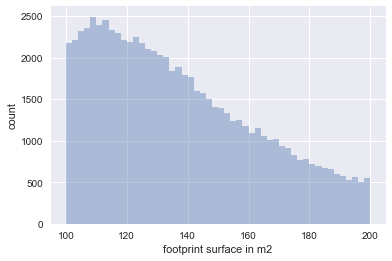

In [82]:
ax = sns.distplot(buildings.area,kde=False)
ax.set(xlabel='footprint surface in m2', ylabel='count')

In [83]:
buildings = buildings.assign(nb_pts=pd.Series(
        [len(list(building.geometry.exterior.coords))for i, building in buildings.iterrows()]).values)

[<matplotlib.text.Text at 0x12b7d87f0>, <matplotlib.text.Text at 0x13247fd30>]

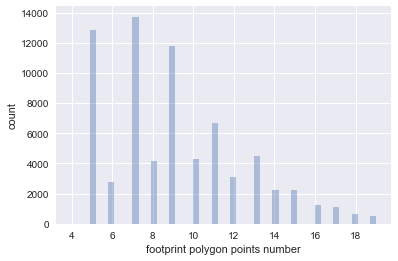

In [84]:
ax = sns.distplot(buildings.nb_pts[buildings.nb_pts<20],kde=False)
ax.set(xlabel='footprint polygon points number', ylabel='count')

In [85]:
# The buildings for whiche the footprint is not a rectangle are removed
buildings = buildings[buildings.nb_pts==5]
buildings = buildings.reset_index()

In [86]:
len(buildings)

12870

## Building images download and visualisation

In [87]:
pics_dir = "data/images"

In [88]:
wms = WebMapService('https://download.data.grandlyon.com/wms/grandlyon')

In [89]:
def get_size_from_bbox(bbox, factor=5):
    '''Gets the size of an image to download in px from the size of a bounding box in meters

    Args:
        bbox: a bounding box in meters.
        factor: the ratio between distances in meters and in px.

    Returns:
        The size of an image in px.
    '''
    size = (bbox[2]-bbox[0], bbox[3]-bbox[1])
    return [int(s * factor) for s in size]

In [90]:
def get_filename(building, subsel, treat):
    '''Gets the path of the image for a building and a given processing
    
    Args:
        building: a geopandas row representing a building.
        subsel: a string representing a selection (e.g. "sample", "full",...).
        treat: a string representing a processing (e.g. "orig",...)
    Returns:
        The path of the image
    '''
    return os.path.join(pics_dir, subsel, treat, str(building.name) + ".jpg")

In [91]:
def get_building_pic(building, wms, subsel, ext=0.0):
    '''Saves the original image to disk for a given building and from a WMS 
    
    Args:
        building: a geopandas row representing a building.
        wms: a wms object from owslib.
        subsel: a string representing a selection (e.g. "sample", "full",...).
        ext: the size of the buffer around the building footprint in meters.
    Returns:
        The path of the image
    '''
    fname = get_filename(building, subsel, 'orig')
    if os.path.isfile(fname):
        return
    bbox_ext = building.geometry.buffer(ext).bounds
    img = wms.getmap(
        layers=['Ortho2015_vue_ensemble_16cm_CC46'],
        styles=[],
        srs='EPSG:2154',
        bbox=bbox_ext,
        size=get_size_from_bbox(bbox_ext),
        format='image/jpeg',
        transparent=True)
    out = open(fname, 'wb')
    out.write(img.read())
    out.close()

In [92]:
def get_poly_rel(building, ext=0.0):
    '''Gets the building footprint in coordinates relative to the image
    
    Args:
        building: a geopandas row representing a building.
        ext: the size of the buffer around the building footprint in meters.
    Returns:
        The building footprint in coordinates relative to the image
    '''
    bbox = building.geometry.bounds
    bbox_ext = building.geometry.buffer(ext).bounds
    orig = bbox_ext[0], bbox_ext[3]
    size = (bbox_ext[2]-bbox_ext[0], bbox_ext[1]-bbox_ext[3])
    poly = list(building.geometry.exterior.coords)
    poly_rel = [[((c-o)/sz) for c,o,sz in zip(pt, orig, size)] for pt in poly]
    return poly_rel

In [94]:
def show_building(building):
    '''Displays a building image and its footprint
        Args:
            building: a geopandas row representing a building.
    '''
    img = cv2.imread(get_filename(building, 'full', 'orig'))
    img_shape = img.shape[1],img.shape[0]
    poly_rel = get_poly_rel(building, ext=10.0)
    poly_img = [[p*sz for p,sz in zip(pt, img_shape)] for pt in poly_rel]
    fig,ax = plt.subplots(1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.axis("off")
    patch = patches.Polygon(poly_img, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(patch)
    plt.show()

In [96]:
# load the images in the data folder (it takes some time)
for i, building in buildings.iterrows():
    get_building_pic(building, wms, 'full', 10.0)

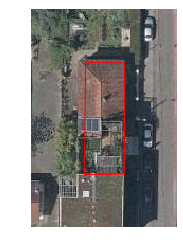

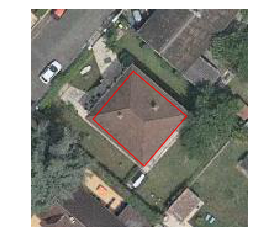

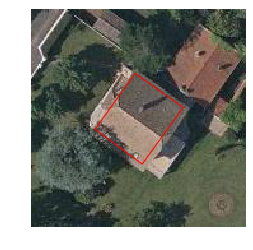

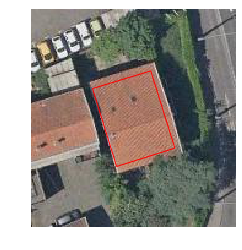

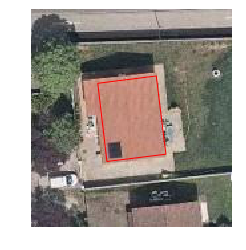

In [99]:
for i, building in buildings.sample(5).iterrows():
    show_building(building)

In [100]:
def show_buildings(buildings, bg_dataset, bboxes_orig=None, bboxes_corr=None, grid_size=(5,5), title=False):
    '''Displays a sample of building images with original and corrected bounding boxes if available.
    
    Args:
        buildings: a geopandas dataframe of buildings.
        bg_dataset: a numpy array containing the building images.
        bboxes_orig: the original footprints coordinates relatively to the image
        bboxes_corr: the corrected footprints coordinates relatively to the image
        grid_size: the size of te grid of images to display
        title: if the name of the building should appear on top of an image
    '''
    fig, axarr = plt.subplots(grid_size[0], grid_size[1], figsize=(20,2*grid_size[0]))
    fig.tight_layout() 
    sort_ind=range(len(buildings))#list(np.argsort(buildings.area))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            k = sort_ind[i*grid_size[1]+j]
            building = buildings.iloc[k]
            bbox_orig = bboxes_orig[k]['bb'] if bboxes_orig is not None else None
            bbox_corr = bboxes_corr[k]['bb'] if bboxes_corr is not None else None
            try:
                img = bg_dataset[k,:,:,:]
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_shape = img.shape[0:2]
            except:
                img = dataset[k,:,:,0]
                img_shape = img.shape
            
            axarr[i, j].imshow(img)
            axarr[i, j].axis("off")
            if title:
                axarr[i, j].set_title(building.name)
            if bbox_orig is not None:
                poly_img = [[p*sz for p,sz in zip(pt, img_shape)] for pt in bbox_orig]
                poly = patches.Polygon(poly_img,
                                         linewidth=1,
                                         edgecolor='r',
                                         facecolor='none')
                axarr[i, j].add_patch(poly)
            if bbox_corr is not None:
                poly_img = [[p*sz for p,sz in zip(pt, img_shape)] for pt in bbox_corr]
                poly = patches.Polygon(poly_img,
                                         linewidth=1,
                                         edgecolor='b',
                                         facecolor='none')
                axarr[i, j].add_patch(poly)
            
    plt.show()  

In [101]:
sample_size = len(buildings)
datasize = [64, 64]
bg_dataset = np.zeros([sample_size]+datasize+[3],dtype=np.uint8)
bg_dataset.fill(255)

In [102]:
for j,(i, building) in enumerate(buildings.iterrows()):
    img = cv2.imread(get_filename(building, 'full', 'orig'))
    img_rz = cv2.resize(img,(datasize[0], datasize[1]),
                         interpolation = cv2.INTER_CUBIC)
    bg_dataset[j,:,:,:] = img_rz

In [103]:
bboxes_orig = []
for i, building in buildings.iterrows():
    poly_rel = get_poly_rel(building, ext=10.0)
    bboxes_orig.append({'name':str(building.name),'bb':poly_rel})

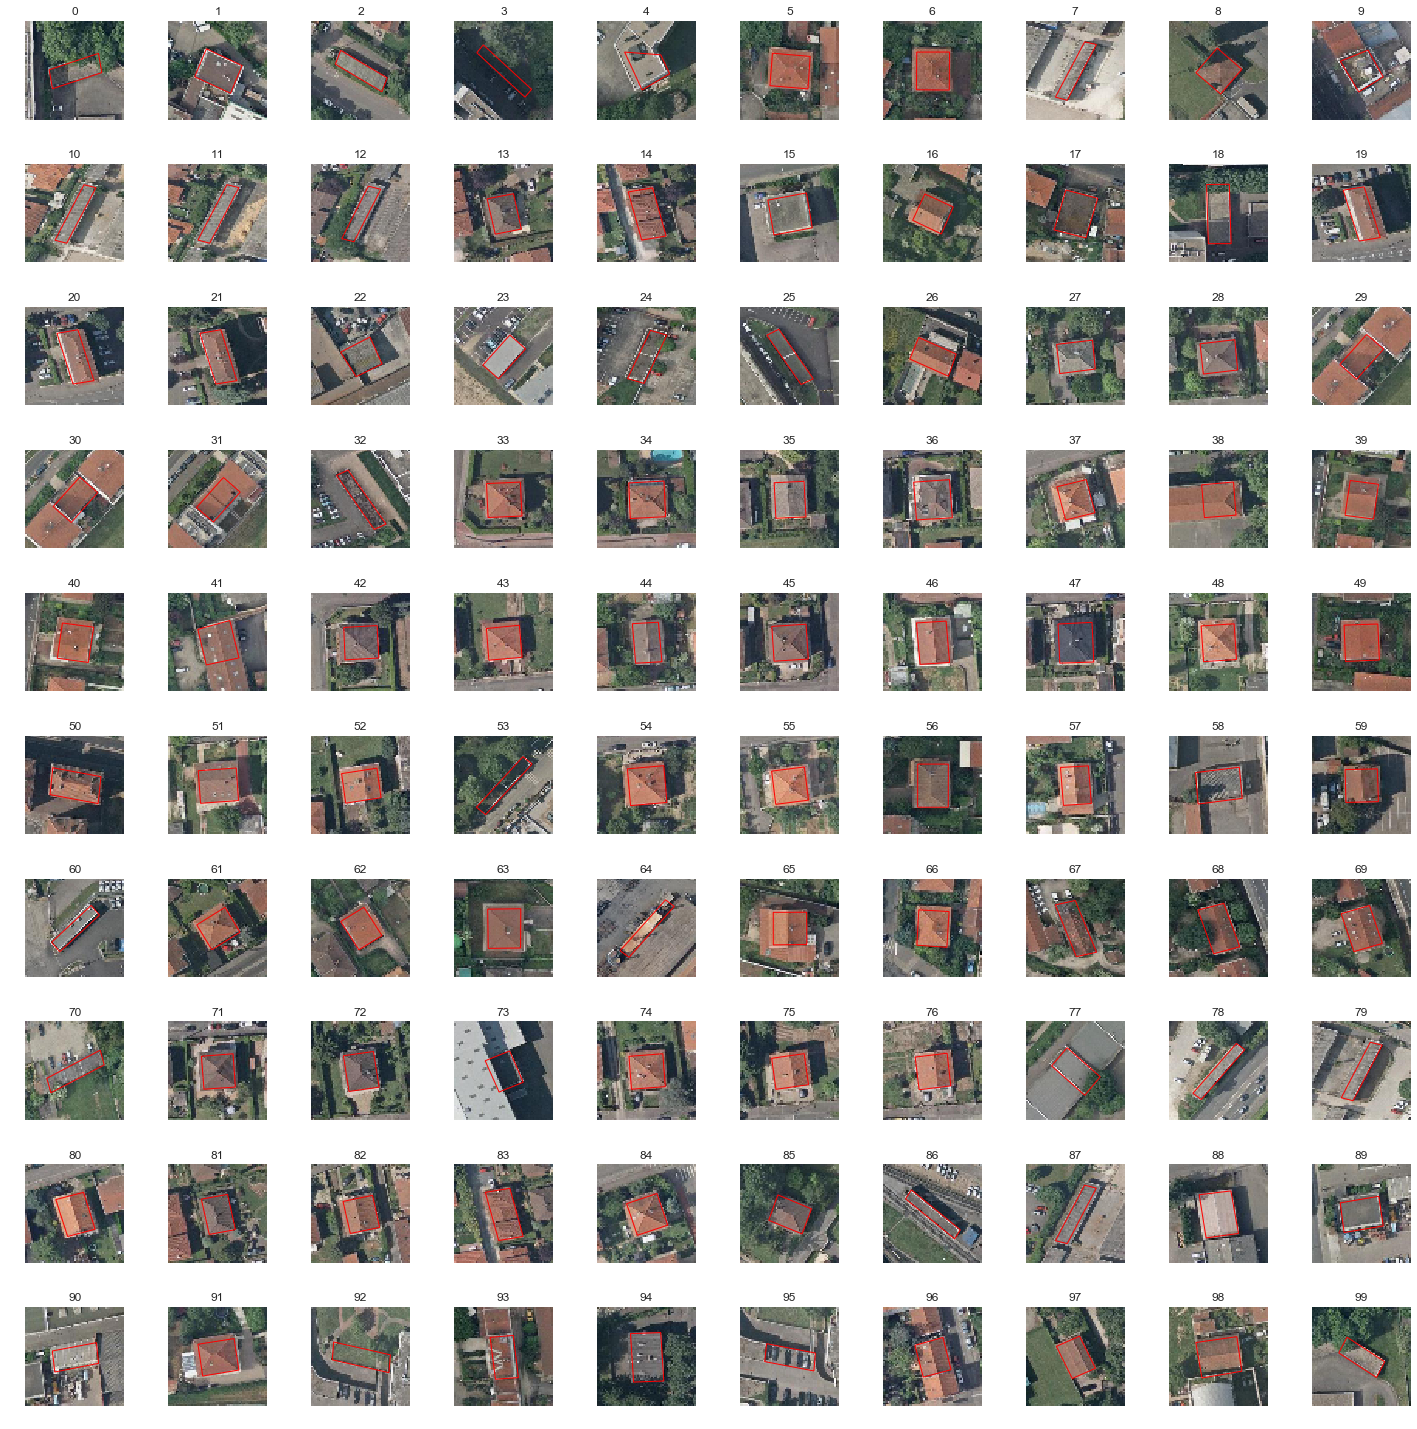

In [105]:
show_buildings(buildings,
               bg_dataset,
               bboxes_orig=bboxes_orig,
               bboxes_corr=None,
               grid_size=(10,10),
                title=True)

## Roof images extraction

In [106]:
def order_points(pts):
    '''Orders the points in a footprint list of ccordinates
    Args:
        pts: the list of points to sort
    Returns:
        The sorted list of points
    '''
    # compute centroid
    cent=(sum([p[0] for p in pts])/len(pts),sum([p[1] for p in pts])/len(pts))
    # sort by polar angle
    spts=sorted(pts,key=lambda p: math.atan2(p[1]-cent[1],p[0]-cent[0]))
    return np.array(spts)

In [107]:
def get_roof(building, subsel, treat):
    '''Extracts a roof image from the building image and stretches it to a square
    Args:
        building: a geopandas row representing a building.
        subsel: a string representing a selection (e.g. "sample", "full",...).
        treat: a string representing a processing (e.g. "orig",...)
    Returns:
        An image of the roof of the building (64,64,3)
    '''
    img_src = cv2.imread(get_filename(building, subsel, treat))
    img_shape = img_src.shape[1],img_src.shape[0]
    poly_rel = list(set([tuple(pt) for pt in get_poly_rel(building, ext=10.0)]))
    pts_src = order_points(np.float32([[p*sz for p,sz in zip(pt, img_shape)] for pt in poly_rel]))
    pts_dst = order_points(np.float32([[0, 0],[0, 64],[64, 64],[64, 0]]))
    M = cv2.getPerspectiveTransform(pts_src,pts_dst)
    img_dst = cv2.warpPerspective(img_src,M,(64,64))
    return img_dst

In [108]:
sample_size = len(buildings.index)
datasize = [64, 64]
roof_dataset = np.zeros([sample_size]+datasize+[3],dtype=np.uint8)
roof_dataset.fill(255)

In [109]:
for i, building in buildings.iterrows():
    roof = get_roof(building, 'full', 'orig')
    roof_dataset[i,:,:,:] = roof

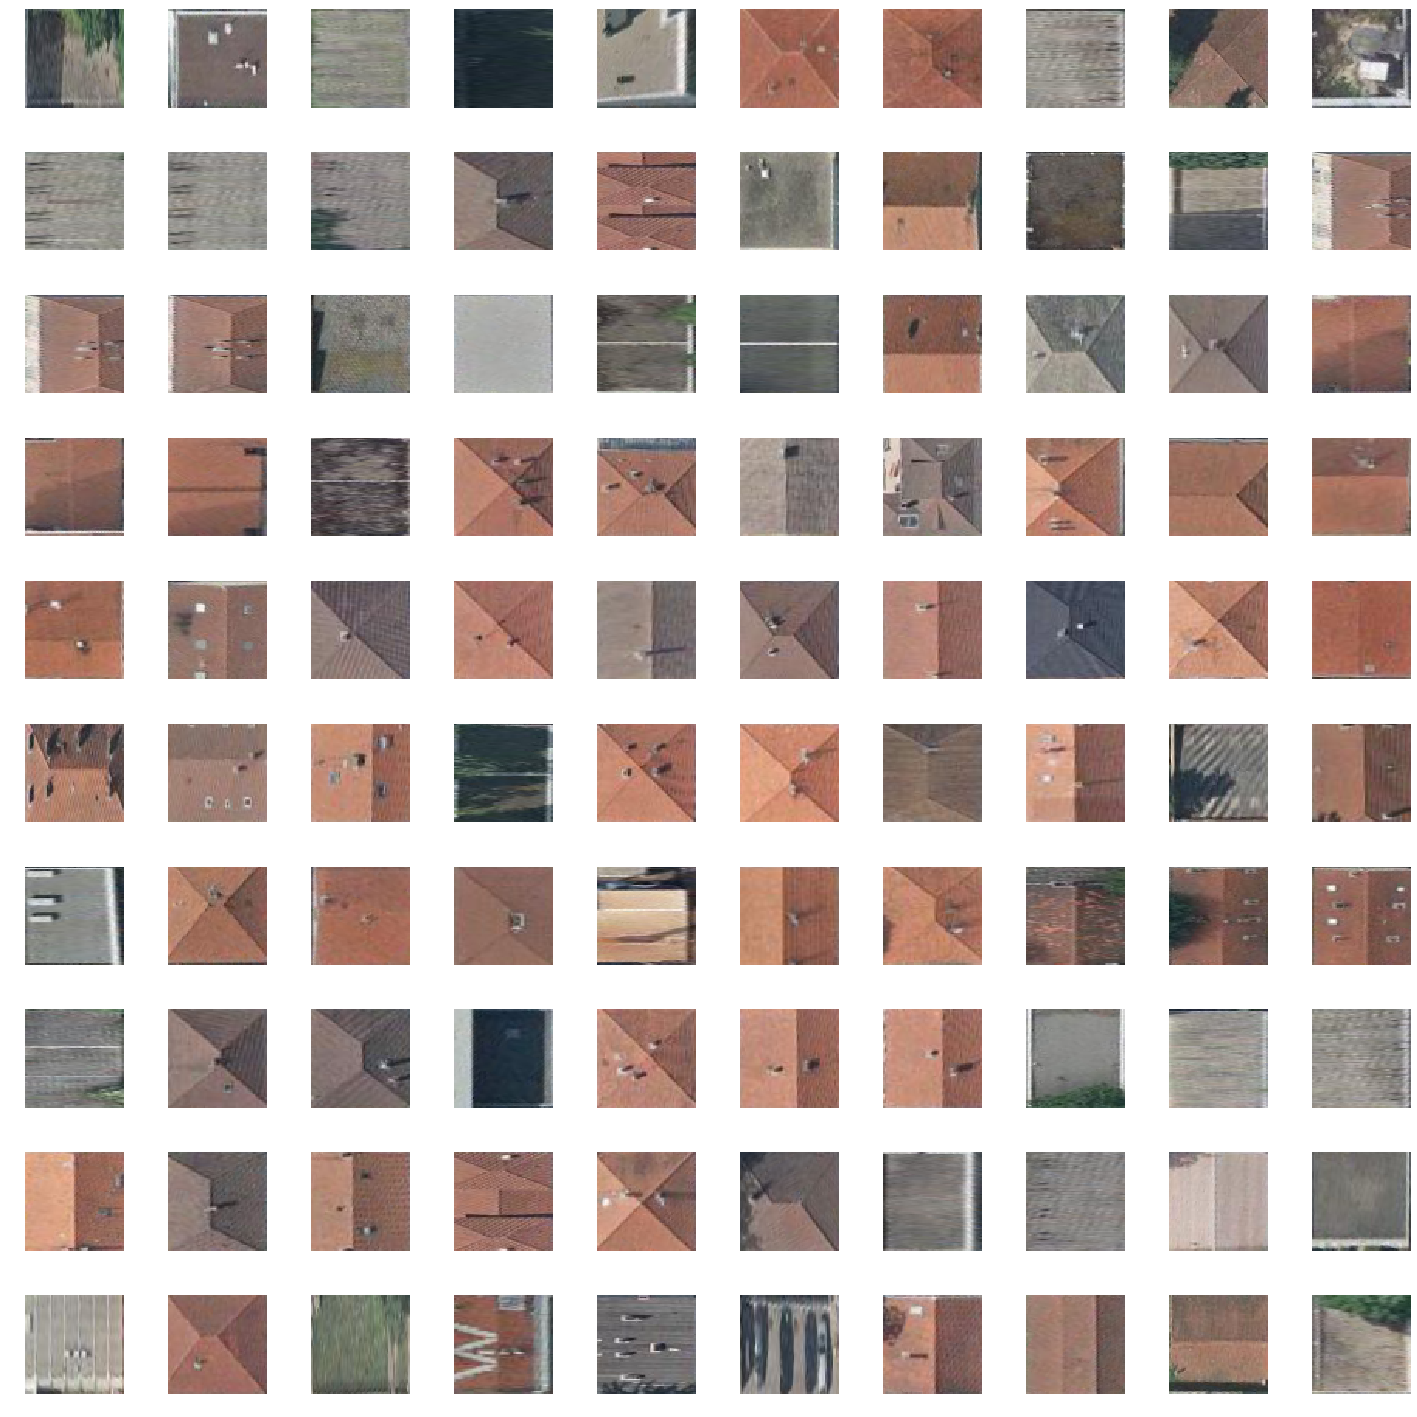

In [112]:
show_buildings(buildings,
               roof_dataset,
               bboxes_orig=None,
               bboxes_corr=None,
               grid_size=(10,10))

In [111]:
# Save data to pickle file

pickle_file = 'data/roof_dataset_prepared.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'bg_dataset': bg_dataset,
    'roof_dataset': roof_dataset,
    'buildings': buildings,
    'bboxes_orig': bboxes_orig
    }
    pickle.dump(save, f, protocol=2)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise